In [7]:
!pip install pyLDAvis.gensim

ERROR: Could not find a version that satisfies the requirement pyLDAvis.gensim (from versions: none)
ERROR: No matching distribution found for pyLDAvis.gensim


In [9]:
import re
import nltk
import nlp
nltk.download('stopwords')
import pandas as pd
import numpy as np

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#spacy for lemmatization
import spacy

#plotting tools
import pyLDAvis
#import pyLDAvis.gensim
#pyLDAvis.enable_notebook()
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Dataset contains BBC news text and its categpry

We want to be able to categorize a news article and have to cluster similar documents by similar topics with LDA

In [10]:
url = 'https://storage.googleapis.com/dataset-uploader/bbc/bbc-text.csv'

df = pd.read_csv(url)
print(df.shape)
df.head()

(2225, 2)


,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


# Preprocess Data

remove emails, newline characters, stopwords and perform tokenization

In [12]:
#convert to list
data = df.text.values.tolist()

#remove emails
data = [re.sub('\s*@\s*\s?', '', i) for i in data]

#remove new line characters
data = [re.sub('\s+', ' ', i) for i in data]

#remove distracting single quotes
data = [re.sub("\'", '', i) for i in data]

<input>:5: DeprecationWarning: invalid escape sequence \s
<input>:5: DeprecationWarning: invalid escape sequence \s
<input>:5: DeprecationWarning: invalid escape sequence \s
<input>:5: DeprecationWarning: invalid escape sequence \s
<input>:8: DeprecationWarning: invalid escape sequence \s
<input>:5: DeprecationWarning: invalid escape sequence \s
<input>:8: DeprecationWarning: invalid escape sequence \s
<input>:5: DeprecationWarning: invalid escape sequence \s
<input>:8: DeprecationWarning: invalid escape sequence \s
<input>:5: DeprecationWarning: invalid escape sequence \s
<input>:8: DeprecationWarning: invalid escape sequence \s
<ipython-input-12-9df9ca17819b>:5: DeprecationWarning: invalid escape sequence \s
  data = [re.sub('\s*@\s*\s?', '', i) for i in data]
<ipython-input-12-9df9ca17819b>:8: DeprecationWarning: invalid escape sequence \s
  data = [re.sub('\s+', ' ', i) for i in data]


In [13]:
#tokenize and clean up text

def sent_to_words(sentences):
  for sentence in sentences:
    yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) #deacc removes punctuation

data_words = list(sent_to_words(data))

print(data_words[:1])

[['tv', 'future', 'in', 'the', 'hands', 'of', 'viewers', 'with', 'home', 'theatre', 'systems', 'plasma', 'high', 'definition', 'tvs', 'and', 'digital', 'video', 'recorders', 'moving', 'into', 'the', 'living', 'room', 'the', 'way', 'people', 'watch', 'tv', 'will', 'be', 'radically', 'different', 'in', 'five', 'years', 'time', 'that', 'is', 'according', 'to', 'an', 'expert', 'panel', 'which', 'gathered', 'at', 'the', 'annual', 'consumer', 'electronics', 'show', 'in', 'las', 'vegas', 'to', 'discuss', 'how', 'these', 'new', 'technologies', 'will', 'impact', 'one', 'of', 'our', 'favourite', 'pastimes', 'with', 'the', 'us', 'leading', 'the', 'trend', 'programmes', 'and', 'other', 'content', 'will', 'be', 'delivered', 'to', 'viewers', 'via', 'home', 'networks', 'through', 'cable', 'satellite', 'telecoms', 'companies', 'and', 'broadband', 'service', 'providers', 'to', 'front', 'rooms', 'and', 'portable', 'devices', 'one', 'of', 'the', 'most', 'talked', 'about', 'technologies', 'of', 'ces', 'ha

In [15]:
#remove stopwords and lemmatize tokens

#NLTK stopwords
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

def remove_stopwords(texts):
  return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

#spacy lemmatization
import spacy 
import en_core_web_sm
nlp = en_core_web_sm.load()

def lemmatization(texts, allowed_postages=['NOUN']):
  texts_out = []
  for sent in texts:
    doc = nlp(" ".join(sent))
    texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postages])
  return texts_out

/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:126: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):


In [ ]:
#remove stop word
data_words_nostops = remove_stopwords(data_words)

#do lem keeping only noun
data_lemmatized = lemmatization(data_words_nostops, allowed_postages=['NOUN'])

In [17]:
print(data_lemmatized[:2]) #print first 2 articles processed

[['tv', 'hand', 'viewer', 'system', 'definition', 'video', 'recorder', 'room', 'way', 'people', 'tv', 'year', 'time', 'expert', 'panel', 'consumer', 'electronic', 'technology', 'trend', 'programme', 'content', 'viewer', 'home', 'network', 'cable', 'satellite', 'company', 'broadband', 'service', 'provider', 'room', 'device', 'technology', 'video', 'recorder', 'dvr', 'pvr', 'box', 'system', 'people', 'record', 'store', 'pause', 'wind', 'tv', 'programme', 'technology', 'tv', 'definition', 'tv', 'business', 'definition', 'programming', 'people', 'wind', 'advert', 'network', 'channel', 'schedule', 'cable', 'satellite', 'company', 'mean', 'term', 'advertising', 'revenue', 'brand', 'identity', 'viewer', 'loyalty', 'channel', 'technology', 'moment', 'concern', 'uptake', 'service', 'sky', 'today', 'month', 'year', 'time', 'issue', 'advertising', 'revenue', 'issue', 'moment', 'brand', 'loyalty', 'content', 'brand', 'network', 'brand', 'communication', 'firm', 'reality', 'broadband', 'producer', 

# LDA Model - Latent Dirichlet Allocation

Unsupervised generative probabilist machine and extracts number of topics in data (corpus), distribution of topics in each text (document) and distribution of words (terms) per topic

Main two inputs are: dictionary of unqiue ids per word and a corpus (each document and number of times of particular word)

LDA Input:

1. M no. of documents

2. Each of these documents have N no. of words

3. Hyperparameters- alpha and beta

4. All of which needs to pass through LDA

LDA Output:

K no. of topics (cluster of words)
Document to topic distribution and Topic-term distribution

α : Per-document topic distribution

High α means every document is likely to contain a mixture of most of the topics and not just any single topic specifically.

Low α means A document is more likely to be represented by just few of the topic.

β : Per topic word distribution

High β means each topic is likely to contain a mixture of most of the words not just any word specifically.

Low β means topic may contain a mixture of just a few of words.

In [18]:
#create dictionary
id2word = corpora.Dictionary(data_lemmatized)
print(id2word)

#create corpus
texts = data_lemmatized

#term document frequency
corpus = [id2word.doc2bow(text) for text in texts]

Dictionary(8785 unique tokens: ['advert', 'advertising', 'book', 'box', 'brand']...)


# Create base model

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                            id2word = id2word,
                                            num_topics = 5,
                                            random_state=100,
                                            chunksize=200,
                                            passes=10,
                                            per_word_topics=True)

In [24]:
# #print the keyowrd in the 5 topics
# import pprint
# pprint(lda_model.print_topics())
# doc_lda = lda_model[corpus]

TypeError: ignored

In [27]:
#Check how good the model is - topic coherence
coherence_model_lda = CoherenceModel(model=lda_model, texts = data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score:', coherence_lda)


Coherence Score: 0.4634110133579211


Topic coherence measures the average similarity between top words having the highest weights in a topic i.e relative distance between the top words.

Let's see if we can improve the coherence further.

# Model Improvement

In [28]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
  """
  Compute c_v coherence for various number of topics

  Params
  dictionary - gensim dict
  corpus - gensim - curpus
  textx = list of input textx
  limit - man number of topics

  Returns
  model list - list of lda topic models
  coherence values - values corresponding to the LDA model with respective number of topics
  """

  coherence_values = []
  model_list = []
  for num_topics in range(start, limit, step):
    model = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                            num_topics = num_topics,
                                            random_state= 100,
                                            chunksize= 200,
                                            passes = 10,
                                            per_word_topics=True,
                                            id2word=id2word)
    model_list.append(model)

    coherencemodel = CoherenceModel(model = model, 
                                    texts = texts, 
                                    dictionary = dictionary,
                                    coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())
  
  return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=data_lemmatized, 
                                                        start=2, 
                                                        limit=8, 
                                                        step =1)

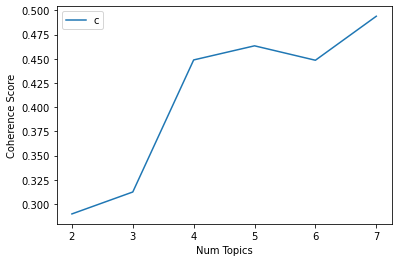

In [30]:
#show plot
limit = 8; start = 2; step =1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence Score")
plt.legend(("coherence_values"), loc="best")
plt.show()

In [31]:
#print the coherence scores
for m, cv in zip(x, coherence_values):
  print("Num Topics =", m, " has Coherence Value of:", round(cv,4))

Num Topics = 2  has Coherence Value of: 0.2897
Num Topics = 3  has Coherence Value of: 0.3124
Num Topics = 4  has Coherence Value of: 0.4488
Num Topics = 5  has Coherence Value of: 0.4634
Num Topics = 6  has Coherence Value of: 0.4485
Num Topics = 7  has Coherence Value of: 0.494


Have you seen the Magic above? In this problem, we already knew that the dataset had 5 sets of articles. So we started with taking no. of topics in the base model as 5 and got topic coherence as 0.49. When we tried to create multiple LDA models for different values of ‘k’ above, we are again getting 5 as the best no. of topics to get the maximum topic coherence before the curve starts decreasing. :)

# Other hyperparams

In [36]:
def compute_coherence_values_2(corpus, dictionary, k, a, b):

    lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                            num_topics = 5,
                                            random_state= 100,
                                            chunksize= 200,
                                            passes = 10,
                                            per_word_topics=True,
                                            id2word=id2word)

    coherencemodel = CoherenceModel(model = lda_model, 
                                    texts = texts, 
                                    dictionary = dictionary,
                                    coherence='c_v')
    return coherencemodel.get_coherence()

In [38]:
import numpy as np
import tqdm

grid = {}
grid['Validation_Set'] = {}

#topics range
min_topics = 2
max_topics = 7
step_size = 1
topics_range= range(min_topics, max_topics, step_size)

#alpha param
alpha = list(np.arange(0.01,1,0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

#beta param
beta = list(np.arange(0.01,1,0.3))
beta.append('symmetric')

In [ ]:
#validation sets
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)),
               corpus]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                 }

if 1 == 1:
  pbar = tqdm.tqdm(total=540)

  for i in range(len(corpus_sets)):
    #iterate through number of topics
    for k in topics_range:
      #iterate through alpha values
      for a in alpha:
        #iterate through beta values
        for b in beta:
          #get coherence score for given params
          cv = compute_coherence_values_2(corpus=corpus_sets[i], dictionary=id2word,
                                          k = k, a = a, b = b)
          #save model results
          model_results['Validation_set'].append(corpus_title[i])
          model_results['Topics'].append(k)
          model_results['Alpha'].append(a)
          model_results['Beta'].append(b)
          model_results['Coherence'].append(cv)

          pbar.update(1)
  pd.DataFrame(model_results).to_csv('lda_tuning_results_new.csv', index=False)
  pbar.close()

This code takes a while to run but we find that the best values were alpha = 0.01, beta = symmetric and no of topics = 5

# Final model

In [42]:
final_model = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                              id2word=id2word,
                                            num_topics = 5,
                                            random_state= 100,
                                            chunksize= 200,
                                            passes = 10,
                                            alpha = 0.01,
                                            eta='symmetric',
                                            per_word_topics=True)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

In [43]:
#Check how good the model is - topic coherence
coherence_model_lda_2 = CoherenceModel(model=final_model, texts = data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda_2 = coherence_model_lda_2.get_coherence()
print('\nCoherence Score:', coherence_lda_2)


Coherence Score: 0.46023941676510577


In [45]:
import pyLDAvis.gensim_models

In [46]:
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(final_model, corpus, id2word)
LDAvis_prepared

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.112398  0.139901       1        1  28.549770
0      0.018972  0.185690       2        1  21.182375
3      0.223958 -0.190405       3        1  17.466955
1     -0.166470 -0.095379       4        1  17.419259
2     -0.188858 -0.039806       5        1  15.381641, topic_info=           Term         Freq        Total Category  logprob  loglift
207        sale  1017.000000  1017.000000  Default  30.0000  30.0000
176        game  1147.000000  1147.000000  Default  29.0000  29.0000
242  government  1034.000000  1034.000000  Default  28.0000  28.0000
15      company   761.000000   761.000000  Default  27.0000  27.0000
57       people  1985.000000  1985.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
51        month   244.688475   798.306218   Topic5  -4.6472   0.6895
294       level   161.037443   302.983000   Topic5  -5.0656   1.2400
309     quarter   148.372696   279.217474   Topic5  -5.1475   1.2397
256        plan   166.805282   583.869795   Topic5  -5.0304   0.6191
182       money   155.333085   451.911295   Topic5  -5.1016   0.8041

[313 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
489       1  0.997826    actor
2356      1  0.994240  actress
867       3  0.979688       ad
410       1  0.138311      age
410       2  0.088284      age
...     ...       ...      ...
96        3  0.049703     year
96        4  0.168026     year
96        5  0.278930     year
567       5  0.967280      yen
1631      4  0.986958  yugansk

[501 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 4, 2, 3])